In [1]:
# based on https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems_(Sayama)/16%3A_Dynamical_Networks_I__Modeling/16.02%3A_Simulating_Dynamics_on_Networks

The model is simple. We construct an Erdos-Renyi graph with $N$ number of nodes, and probability of formation of edges between nodes as $p$. Each node and existing edge is randomly assigned a value $v_i \in [0,1]$ and $w_{ij} \in [0,1]$, respectively. Then, at every iteration, two random nodes $i$ and $j$ are chosen, and if $|v_i - v_j| < \epsilon$, where $\epsilon$ is a minimum difference of opinions for two nodes to influence each other, then their values are updated by 
\begin{equation}
\begin{split}
&\frac{dv_i}{dt} = v_i + w_{ij}*(v_i - v_j)\\
&\frac{dv_j}{dt} = v_j + w_{ij}*(v_j - v_i)
\end{split}
\end{equation}.

This differs from the standard Deffuant model, in the sense that $w_{ij}$ is replaced by a constant parameter $\mu$ in the original model, which is the multiplier that describes the relative agreement between subjects (nodes) in a social network \cite{marconi2020opinion}.

Thus, $w_{ij}$ is updated at each iteration, after nodes $i$ and $j$ are updated, by 
\begin{equation}
\dot w_{ij} = \begin{cases} 
      max(0, w_{ij} + |v_i - v_j|) \quad \text{ if }w_{ij} \le \tau\\
      max(0, w_{ij} - |v_i - v_j|) \quad  \text{otherwise}\\ 
   \end{cases}
\end{equation}.

Hence, if the difference in opinion between nodes $i$ and $j$ is smaller than the threshold value $\tau$, their strength of relationship (weight $w_{ij}$) increases and decreases otherwise. Though this model is limited in the sense that it does not account for edges forming between nodes that otherwise previously aren't connected. N.B. this model is just a simple implementation to show network adaptivity, and is not a realistic model, the equations and hyperparameters are not empirically verified.

Choosing $N = 30, p = 0.5, \epsilon = 0.4, \tau = 0.15$, for one of the implementations, we observe that nodes synchronize over time towards the same opinion strength (lower opinion value as their colours become lighter). Some of their weights also decrease, indicating that the corresponding relationships become weaker.

In [2]:
pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import sys 
import os
sys.path.append(os.path.abspath("C:/Users/124109249/Downloads"))
import pycxsimulator

In [13]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pycxsimulator
# pycxsimulator can be downloaded from https://github.com/hsayama/PyCX/blob/master/pycxsimulator.py

# Parameters
N = 30  # Number of nodes
p = 0.5  # Probability of edge creation
epsilon = 0.4  # Confidence threshold for interaction
tau = 0.15 # threshold opinion difference to increase or decrease weight
t = 0

def initialize():
    global g, pos
    g = nx.erdos_renyi_graph(N, p)  # create erdos renyi graph with N nodes and probability of edge forming being 0.5
    pos = nx.spring_layout(g)  # layout positions of nodes

    #  initialise opinion value randomly from [0,1]
    for node in g.nodes:
        g.nodes[node]['opinion'] = random.random()
        
    # initialise weight (perhaps relationship strength) randomly from [0,1]
    for node1, node2 in g.edges:
        
        g[node1][node2]['weight'] = random.random() 

def observe():
    global g
    plt.cla()
    
    # get node states (opinion value)
    opinions = [g.nodes[node]['opinion'] for node in g.nodes]
    
    # get weight between nodes
    edge_weights = [g[u][v]['weight'] for u, v in g.edges]
    
    # get minimum weight and maximum weight to perform min-max normalisation for colormapping values
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    edge_colors = [plt.cm.viridis((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights]
    
    # draw the network with node colours representing intensity of opinions, 
    # weight colour representing strength of connection between nodes
    nx.draw(g, pos=pos, node_color=opinions, cmap='coolwarm', vmin=0, vmax=1, with_labels=True, width=edge_weights, edge_color=edge_colors)
    plt.draw()

def update():
    global g
    
    # select a random edge connecting 2 nodes
    if g.edges:
        node1, node2 = random.choice(list(g.edges))

        # fetch the states of the 2 nodes
        opinion1 = g.nodes[node1]['opinion']
        opinion2 = g.nodes[node2]['opinion']

        # update changes in node states only when the absolute difference of their states is smaller than epsilon
        if abs(opinion1 - opinion2) < epsilon:
            new_opinion1 = opinion1 + g[node1][node2]['weight'] * (opinion2 - opinion1)
            new_opinion2 = opinion2 + g[node1][node2]['weight'] * (opinion1 - opinion2)

            # update the new states of the nodes
            g.nodes[node1]['opinion'] = new_opinion1
            g.nodes[node2]['opinion'] = new_opinion2
            
            # update weight between the two nodes
            # For example, use the opinion difference to adjust the weight
            weight_change = abs(opinion1 - opinion2)  
            if weight_change <= tau:
                g[node1][node2]['weight'] = max(0, g[node1][node2]['weight'] + weight_change)  # ensure positive weight
            elif weight_change > tau:
                g[node1][node2]['weight'] = max(0, g[node1][node2]['weight'] - weight_change)

# Start the simulation
pycxsimulator.GUI().start(func=[initialize, observe, update])

Sample Results

Initial state:
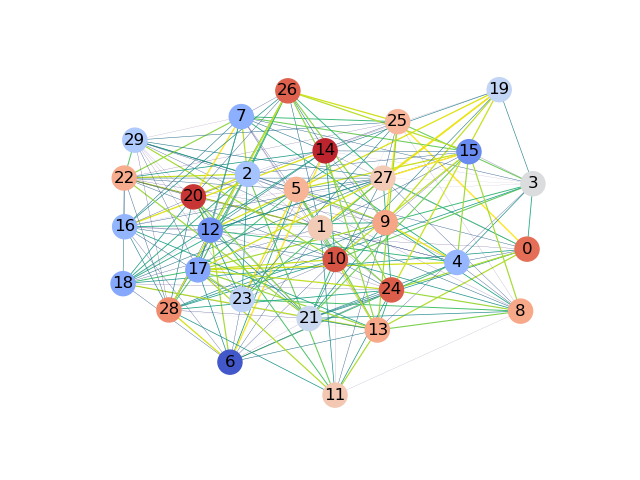

After some iterations:
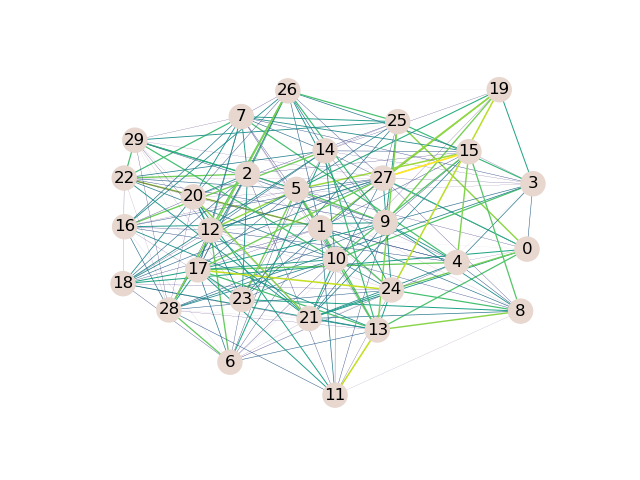